In [ ]:
def target_load(initial_load: np.ndarray, load_high: float, load_low: float, max_load_step: float)-> float:
    """Takes initual load perctentage and returns target load percentage

    Parameters
    ----------
    initial_load : np.ndarray
        Initial load percentage
    load_high : float
        Upper load percentage limit.
    load_low : float
        Lower load percentage limit.
    max_load_step : float
        Max percentage difference between initial_load and target load

    Returns
    -------
    float
        target load percentage
    """
    max_val = initial_load + max_load_step
    min_val = initial_load - max_load_step
    if initial_load > load_high - max_load_step:
        return np.random.uniform(min_val, load_high)
    elif initial_load < load_low + max_load_step:
        return np.random.uniform(load_low, max_val)
    else:
        return np.random.uniform(min_val, max_val)

target_load_vect = np.vectorize(target_load)

In [ ]:
final_values = target_load_vect(initial_load_values, load_high, load_low, max_load_step)
final_values = np.around(final_values, 2)

In [ ]:
print(np.where(final_values > load_high - max_load_step)[0].shape)

In [ ]:
print(np.where(initial_load_values > load_high - max_load_step)[0].shape)

In [ ]:

counts, bins = np.histogram(final_values)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Distribución valores finales')

plt.show()

In [ ]:


with open("IEEE34_form1_loads.atp", "r+") as f:
    lines = f.readlines()
lines_copy = lines.copy()
def loop():
    for idx, line in enumerate(lines_copy):
        if 'C Load' in line:
            if '3f' in line:
                print(line, end='')
                print(f" Fase A carga trifásica/bifásica: {lines_copy[idx + 1]}", end='')
                print(f" Fase B carga trifásica/bifásica: {lines_copy[idx + 2]}", end='')
                print(f" Fase C carga trifásica/bifásica: {lines_copy[idx + 3]}", end='')
            else:
                print(line, end='')
                print(f" Fase A carga monofásica: {lines_copy[idx + 1]}", end='')

%timeit loop()

In [486]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm


# Distribución normal truncada
def get_truncated_normal(
    mean: float = 0, sd: int = 1, low: float = 0, upp: float = 10
) -> np.ndarray:
    """Return array of truncated normal distribution with:
    mean = mean
    standard deviation = sd
    lower limit = low
    upper limit = upp

    Parameters
    ----------
    mean : float, optional
        Truncated distribution Mean, by default 0
    sd : int, optional
        Truncated distribution standard deviation, by default 1
    low : float, optional
        Truncated distribution lower limit, by default 0
    upp : float, optional
        Truncated distribution upper limit, by default 10

    Returns
    -------
    np.ndarray
        Array of truncated normal distribution
    """
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


def load_split(
    array: np.ndarray, len_a: int, len_b: int, len_c: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Splits array of normal distribution load percentages into
    three new arrays, one for each phase.

    Parameters
    ----------
    array : np.ndarray
        Array of percentages
    len_a : int
        Amount of loads on phase A
    len_b : int
        Amount of loads on phase B
    len_c : int
        Amount of loads on phase C

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        load percentages split for phase A, B and C, respectively
    """
    a = array[:len_a]
    b = array[len_a : len_a + len_b]
    c = array[len_a + len_b :]
    return a, b, c


# Graficar histograma de los nuevos datos
def plot_hist(data: np.ndarray, title: str):
    """Plots histogram of distribution of percentages

    Parameters
    ----------
    data : np.ndarray
        Numpy array with load percentages
    title : str
        Title for plot and prints
    """
    counts, bins = np.histogram(data)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.title(f"Distribución valores {title}")
    plt.show()
    print(f"Promedio de las cargabilidades {title} individuales: {np.mean(data)}")
    print(f"Cargabilidad mínima: {min(data):0.4}, cargabilidad máxima: {max(data):0.4}")


# Validación suma admitancias serie
with open("IEEE34_form1_update_loads.atp", "r+") as f:
    lines = f.readlines()
lines_copy = lines.copy()
three_phase_loads = []
Za = np.empty((0, 2))
Zb = np.empty((0, 2))
Zc = np.empty((0, 2))

Ztotal = 0
for idx, line in enumerate(lines_copy):
    if "C Load" in line:
        if "3f" in line:
            # print(lines_copy[idx + 1], end="")
            # print(lines_copy[idx + 2], end="")
            # print(lines_copy[idx + 3], end="")
            Ra = float(lines_copy[idx + 1][30:42])
            Xa = float(lines_copy[idx + 1][46:58])
            za = Ra + Xa * 1j
            if not np.abs(za) > 1e20:
                Za = np.append(Za, [[idx + 1, za]], axis=0)

            Rb = float(lines_copy[idx + 2][30:42])
            Xb = float(lines_copy[idx + 2][46:58])
            zb = Rb + Xb * 1j
            if not np.abs(zb) > 1e20:
                Zb = np.append(Zb, [[idx + 2, zb]], axis=0)

            Rc = float(lines_copy[idx + 3][30:42])
            Xc = float(lines_copy[idx + 3][46:58])
            zc = Rc + Xc * 1j
            if not np.abs(zc) > 1e20:
                Zc = np.append(Zc, [[idx + 3, zc]], axis=0)

        else:
            R = float(lines_copy[idx + 1][30:42])
            X = float(lines_copy[idx + 1][46:58])
            z = R + X * 1j
            if " A" in line:
                Za = np.append(Za, [[idx + 1, z]], axis=0)
            if " B" in line:
                Zb = np.append(Zb, [[idx + 1, z]], axis=0)
            if " C" in line:
                Zc = np.append(Zc, [[idx + 1, z]], axis=0)


In [487]:
# Find Y total for each phase
Ya = 1 / Za[:, 1]
Yb = 1 / Zb[:, 1]
Yc = 1 / Zc[:, 1]
Ya_total = np.sum(Ya)
Yb_total = np.sum(Yb)
Yc_total = np.sum(Yc)

Y_total = Ya_total + Yb_total + Yc_total

len_a = Za.shape[0]
len_b = Zb.shape[0]
len_c = Zc.shape[0]
load_amount = len_a + len_b + len_c

cargabilidad_inicial = 0.90
cargabilidad_final = 0.95
delta_cargabilidad = cargabilidad_final - cargabilidad_inicial

initial_load = (
    get_truncated_normal(mean=cargabilidad_inicial * 100, sd=1, low=0, upp=200).rvs(
        load_amount
    )
    / 100
)
target_load = (
    get_truncated_normal(mean=delta_cargabilidad * 100, sd=1, low=-10, upp=10).rvs(
        load_amount
    )
    / 100
)
target_load_2 = (
    get_truncated_normal(mean=cargabilidad_final * 100, sd=1, low=30, upp=200).rvs(
        load_amount
    )
    / 100
)




initial_a, initial_b, initial_c = load_split(initial_load, len_a, len_b, len_c)
target_a, target_b, target_c = load_split(target_load, len_a, len_b, len_c)
target_a_2, target_b_2, target_c_2 = load_split(target_load_2, len_a, len_b, len_c)
# plot_hist(initial_load, 'Initial')
# plot_hist(target_load, 'Target')
# plot_hist(target_load_2, 'Target_2')

# Admitancias por fase iniciales y finales
Ya_initial, Yb_initial, Yc_initial = Ya * initial_a, Yb * initial_b, Yc * initial_c
Ya_target_2, Yb_target_2, Yc_target_2 = Ya * target_a_2, Yb * target_b_2, Yc * target_c_2
Ya_target = Ya_initial * target_a + Ya_initial
Yb_target = Yb_initial * target_b + Yb_initial
Yc_target = Yc_initial * target_c + Yc_initial

# Admitancia total luego de la variación de carga
Y_initial_total = Ya_initial.sum() + Yb_initial.sum() + Yc_initial.sum()
Y_target_total = Ya_target.sum() + Yb_target.sum() + Yc_target.sum()
Y_target_total_2 = Ya_target_2.sum() + Yb_target_2.sum() + Yc_target_2.sum()

# Procentaje de Cambio
print(
    f"Porcentaje de cargabilidad inicial real: {abs(Y_initial_total) / abs(Y_total):.3%}"
)
print(
    f"Porcentaje de cargabilidad final real: {abs(Y_target_total) / abs(Y_total):.3%}"
)
print(
    f"Porcentaje de cargabilidad final real 2: {abs(Y_target_total_2) / abs(Y_total):.3%}"
)
print(
    f"Porcentaje de cambio entre inicial y final: {abs(Y_target_total - Y_initial_total )/ abs(Y_initial_total):.3%}"
)
print(
    f"Porcentaje de cambio entre inicial y final 2: {abs(Y_target_total_2 - Y_initial_total )/ abs(Y_initial_total):.3%}"
)


Porcentaje de cargabilidad inicial real: 90.376%
Porcentaje de cargabilidad final real: 94.907%
Porcentaje de cargabilidad final real 2: 95.292%
Porcentaje de cambio entre inicial y final: 5.013%
Porcentaje de cambio entre inicial y final 2: 5.439%


In [488]:
# Hallar impedancias a partir de las admitancias
Za_initial = 1 / Ya_initial
Zb_initial = 1 / Yb_initial
Zc_initial = 1 / Yc_initial
Za_target = 1 / Ya_target
Zb_target = 1 / Yb_target
Zc_target = 1 / Yc_target


In [489]:
print(Za_initial.shape)
print(Za.shape)
Za_ini = np.append([Za[:, 0]], [Za_initial], axis=0).T
Za_tar = np.append([Za[:, 0]], [Za_target], axis=0).T
Zb_ini = np.append([Zb[:, 0]], [Zb_initial], axis=0).T
Zb_tar = np.append([Zb[:, 0]], [Zb_target], axis=0).T
Zc_ini = np.append([Zc[:, 0]], [Zc_initial], axis=0).T
Zc_tar = np.append([Zc[:, 0]], [Zc_target], axis=0).T
print(Za_ini[:,1])
print(Za)
print(f"{Za_ini[0,1].real:.6f}")
print(f"{Za_ini[1,1].real:.6f}")
print(f"{Za_ini[2,1].real:.6f}".center(12))
print(f"{Za_ini[0,1].imag:6.6f}".center(12))


(27,)
(27, 2)
[  6983.76682794  +5587.01346238j  15858.91814223 +12334.71411013j
   1046.65581873   +814.06563679j  54916.61184113 +27458.30592057j
  21229.01858174 +16983.21486584j  10905.93255333  +5452.96627666j
  10813.44363725  +5406.72181863j   2707.40525181  +1403.83976025j
   2645.2268665   +1371.59911601j  60999.91945074 +30499.95972537j
  61312.67233794 +30656.33616897j  91545.32639645 +45772.66319822j
 166843.97743285 +71504.56175518j 167462.87493898 +71769.80354352j
 182627.83125104 +91313.91562552j 185326.24174612 +92663.12087306j
  69176.93293596 +34588.46646798j  69369.27664164 +34684.63832082j
 270438.73403944+135219.36701972j 274092.46273024+137046.23136512j
  39350.91965217 +21861.62202886j  39091.80614488 +21717.67008037j
  37012.97153613 +18506.48576806j  36649.77117376 +18324.88558688j
  42407.73699617 +19176.34819215j  55493.32334927 +23782.8528635j
  55001.07378373 +23571.88876398j]
[[   963.             +0.j           6300.9146341   +5040.7317073j ]
 [  1137.   

In [491]:
def update_loads(Z_array: np.ndarray, lines_copy: list) -> list:
    """Returns list of lines with updated impedances

    Parameters
    ----------
    Z_array : np.ndarray
        Array of indices and impedances (complex number).
        Dimension (m, 2), where
            m = number of impedances
            (,0) = indices column
            (,1) = impedances column
    lines_copy : list
        List with .atp file content

    Returns
    -------
    list
        List of .atp file content with updated impedances
    """
    for Z in Z_array:
        idx = Z[0]
        z = Z[1]

        idx = int(idx)
        R = f"{z.real:.6f}".center(12)
        X = f"{z.imag:.6f}".center(12)
        line = lines_copy[idx]
        new_line = f"{line[:30]}{R}{line[42:46]}{X}{line[58:]}"

        lines_copy[idx] = new_line
    return lines_copy


with open("IEEE34_form1_update_loads_prueba.atp", "w+") as f:
    lines_copy = update_loads(Za_ini, lines_copy)
    lines_copy = update_loads(Zb_ini, lines_copy)
    lines_copy = update_loads(Zc_ini, lines_copy)
    f.writelines(lines_copy)

    # f.writelines(lines_copy)


C:\Users\aherrada\AppData\Local\Temp\ipykernel_17208\2209880086.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  idx = int(idx)


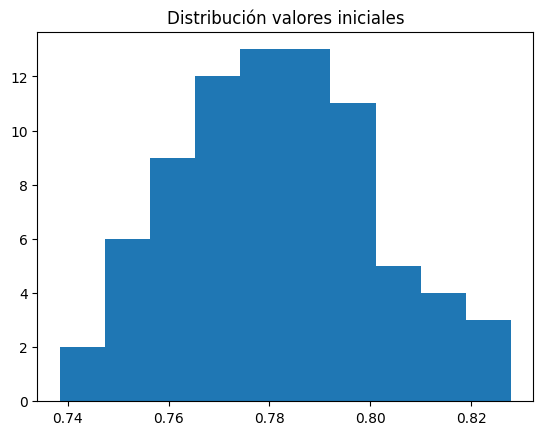

Promedio de las cargabilidades iniciales individuales: 0.7816295497892887
Cargabilidad mínima: 0.7385, cargabilidad máxima: 0.8278


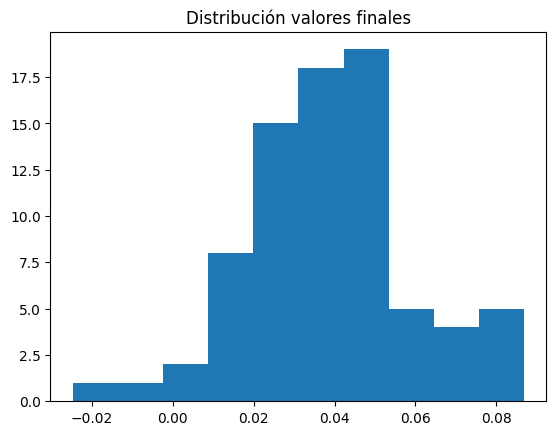

Promedio de las cargabilidades finales individuales: 0.039222548604317634
Cargabilidad mínima: -0.02466, cargabilidad máxima: 0.0868


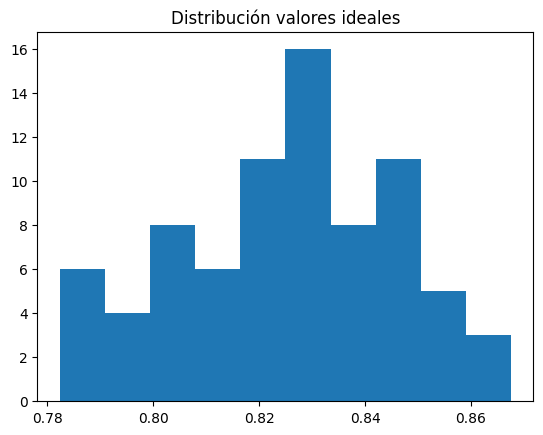

Promedio de las cargabilidades ideales individuales: 0.8249655434260246
Cargabilidad mínima: 0.7824, cargabilidad máxima: 0.8675
0.030669756771441924
Cargabilidad promedio método 1: 0.8122993065607306
Cargabilidad promedio ideal: 0.8249655434260246


In [20]:
cargabilidad_inicial = 0.78
cargabilidad_final = 0.82
delta_cargabilidad = cargabilidad_final - cargabilidad_inicial






initial_load = (
    get_truncated_normal(mean=cargabilidad_inicial * 100, sd=2, low=30, upp=200).rvs(load_amount) / 100
)
target_load = (
    get_truncated_normal(mean=delta_cargabilidad * 100, sd=2, low=-10, upp=10).rvs(load_amount) / 100
)
real_target_load = (
    get_truncated_normal(mean=cargabilidad_final * 100, sd=2, low=-30, upp=200).rvs(load_amount) / 100
)
# Graficar la nueva distribución de datos
plot_hist(initial_load, "iniciales")


plot_hist(target_load, "finales")


plot_hist(real_target_load, "ideales")


print(np.mean(target_load*initial_load))
print(f"Cargabilidad promedio método 1: {np.mean(initial_load + target_load*initial_load)}")
print(f"Cargabilidad promedio ideal: {np.mean(real_target_load)}")

### Validación obtención admitancias 

##### Suposiciones:

- El voltaje en todos los nodos es igual al voltaje nominal
- Las fases están balanceadas
- La cargabilidad del sistema está solo determinado por las cargas (i.e. no se consideran pérdidas en líneas ni otros elementos.)